# Imports


In [ ]:
# Only needed if brian2 is not installed.
#!pip3 install brian2

     |████████████████████████████████| 1.2MB 6.0MB/s 
     |████████████████████████████████| 5.8MB 36.8MB/s 
  Created wheel for brian2: filename=Brian2-2.4.2-cp36-cp36m-linux_x86_64.whl size=1257517 sha256=b8d25f30d252915b237373c24fbbb8dc6a547950159fe17fe29fb229779c6f5b
  Stored in directory: /root/.cache/pip/wheels/5d/4b/cf/ef50e71df5479d67f981cbb17b1d842381019d27ba144d57de
Successfully built brian2
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [ ]:
# Brian 2 recommended imports.
from brian2 import *
%matplotlib inline

# Numpy.
import numpy as np


# *The Izhikevich’s model*.






The Izhikevich’s model is an specific model for spiking neurons, designed by Eugene M. Izhikevich. The goal of the model is to be able to represent several neuron specific patters without incurring into high costs.

The model will be created later, for now we just define several usefull functions that will help us making the model function cleaner and shorter.

We are gonna define 2 small functions, one of them just prints the parameters the model is using (the original parameters that are feed into it), while the other one uses 2 brian2 monitors.

A monitor is a "recorder" of what is happening to the neuron (or net, if there is more than one). One of the monitors just records the spikes (the moment when the spike happens) and the other one records the values of I and V. What I and V are we will explain later.


In [ ]:
# Function to print the parameters of the model.
#   Precondition: The parameters of the model.
#   Postcondition: Prints the parametres of the model.
def printParameters(n_neurons, a, b, c, d, cInjection, v0, tau, time, u0,k1, k2, k3, injectionMode):
      print('''The chosen parameters are: 
        Number of Neurons = ''', n_neurons,
        '''
        a = ''', a,
        '''
        b = ''', b,
        '''
        c = ''', c,
        '''
        d = ''', d,
        '''
        cInjection = ''', cInjection,
        '''
        v0 = ''', v0,
        '''
        u0 = ''', u0,
        '''
        k1 = ''', k1,
        '''
        k2 = ''', k2,
        '''
        k3 = ''', k3,
        '''
        tau = ''', tau,
        '''
        Time = ''', time,
        '''
        injectionMode = ''', injectionMode)
        
# Fuction to print the outcome of the model.
#   Precondition: A brian2 spike monitor and a brian2 normal Monitor.
#   Postcondition: Print the graph showing the outcome of the model
def printOutcome(vMonitor, spkMonitor):
    plt.figure(figsize=(10,5))
    plt.plot(vMonitor.t/ms, vMonitor.v[0], c='orange')
    plot(vMonitor.t/ms, vMonitor.I[0], label='I')
    plt.axhline(30, ls='-', c='C6', lw=2, label='Threshold')
    for time in spkMonitor.t:
        plt.axvline(time/ms, c='k', lw=.3)
    plt.xlabel('Time (ms)')
    plt.ylabel('V, I')
    plt.legend()
    plt.show()
    
    

Now we need to tackle the main function: the one that modelates the Izhikevich spiking neuron / neural net model.

***The parametres of the fucntion:***

The model uses a lot of parameters, luckily, when modelating neuron patterns, some of them end up being default values that can be declared on the function header. This parametres are:


*   n_neurons: Default value = 1. This parameter defines the number of neurons we are gonna use. For every pattern on this notebook, this number should be 1. 

*   a: Default value = 0.02. This parameter defines the time scale of the recovery variable u.

*   b: Default value = 0.2. This parameter defines the sensitivity of the recovery variable u to the subthreshold fluctuations of the membrane potential v.

*   c: Default value = -65. This parameter defines the after-spike reset value of the membrane potential v.

*   d: Default value = 2. This parameter defines the after-spike reset of the recovery variable u.

*   v0: Default value = -65. This parameter defines the initial membrane potential.

*   tau: Default value = 10. This parameter defines the time step.

*   time: Default value = 2500. This parameter defines the time the simulation will run.

*   cInjection: Default value = "10". It represents the input current. This value can be a normal number (a constant) or it can be a string expression. This is usefull to gain precision with controlled input currents. An example of an expression that gives the parameter the value 20 when t (time unit) is above 10ms could be:   
  ```python
  "20*(t>=10*ms)"
  ```

*   u0: Default value = "empty". This parameter defines the initial value of u in the function. If left "empty", it will automatically assign the value b*v0, if introduced a costant number, it will assign that number. This is used since on a particular example, Izhikevich uses a different starting value and a different definiton of du/dt. 

*   diferential_constants: Default value = "empty". This parameter defines the constants of the dv/dt function. If left "empty", it will introduce the default values of the constants (0.04, 5, 140). If intoduced a numpy array of size 3, it will introduce the values of the array as constants. Example: [p1,p2,p3] will assign constant 1 p1, constant 2 p2 and constant 3 p3. This is usefull since it turns out that in a few of Izhikevich’s examples he changes up the values of some of constants in the dv/dt equation. 

*   injectionMode: Default value = "once". This parameter defines if the injection is done once of it it repearts every milisecond. This is usefull and mostly used when an expression is introduced as a parameter in cInjection, since we need to check if the expression is true or false on every step of the run. To change to this mode, the parameter sould be introduces as:
```python
injectionMode = "dinamic"
```

***The equations of the model:***


This model is based on 2 main equation systems, one system is the general equations that made the model work. These are the following:
```
  dv/dt = 0.04v^2 + 5v + 140 - u + I
  du/dt = a(bv-u)
```
These equations model the general behavior of the neuron. Yet this equation has a couple of variables we havent explained yet. These are:

* v: variable that represents the membrane potential of the neuron.

* u: variable that represents a membrane recovery variable which provides negative feedback to v.

* I: variable that represents the input current.

The second system defines what happens when v reaches its threshold value (30). When that happens, the following equation system is used as a reset system:
```
v = c
u = u + d
```

***The equations in our model:***

A quick eye will have noticed that in our model the equations are a bit different. The general equations dont take into account the time step, we needed to add it. We also define the main equation dv/dt differently, with the constants as variables. As mentioned in the parameter explanation, this is because it turns out that in a few of Izhikevich’s examples he changes up the values of some of constants in it. So we just declared the constants as 3 variables that can be changed throught the parameters of the function.
```
dv/dt = (k1*v**2 + k2*v + k3 - u + I)/tau : 1
du/dt = a*((b*v) - u)/tau : 1
```
The rest of our model is just normal self-contained brian2 simulation procedures, with no special features.

***A strange case: The (R) Accomodation pattern.***

The (R) accomodation pattern supposes a problem to our model, since to generate that exact pattern, Izhikevich overall changes the entire du/dt equation. Since there is no easy way to get that equation also a parameter, and making another model just for a small change seems excessive, we decided that when that pattern wants to be created, the du/dt function must be changed to ```du/dt = a*(b*(v+65))/tau : 1``` manually. For this strange case there is also a parameter that must be used, and thats giving the u0 the following value:
```python
u0=-16
```

In [ ]:
# Original Function to model the Izhikevich SNN model.
# Since we are simulating a single cell (spiking-neuron model) , the value of n_neurons is default to 1.
# The option to work with more neurons is accepted, but is not recommended,
# since we dont use synapses anyway, and this is used to model a single neuron.
# Is there just in case anyone wants to do tests.
    # Precondtion: The parameters.
    # Outcome: Graphs showing the behaviour of the neuron.
def Izh_spiking_model(n_neurons=1, a=0.02, b=0.2, c=-65, d=2, v0=-65, 
                      tau=10, time=2500,  cInjection='10',  
                      u0 = "empty", diferential_constants = "empty", 
                      injectionMode = "once"  ):

    # Start brian 2 with a new scope.
    start_scope()

    # Check the u0 value, if its empty, give it the default value.
    if u0 == "empty":
      u0 = b*v0
    
    # Check the constant values. If they are empty, give them the default values.
    # Else, assign the new costant values to the costants.
    if diferential_constants == "empty":
      k1 = 0.04
      k2 = 5
      k3 = 140
    else:
      k1 = diferential_constants[0];
      k2 = diferential_constants[1];
      k3 = diferential_constants[2];

    # Print the parameters of the function.
    printParameters(n_neurons, a, b, c, d, 
                    cInjection, v0, tau, time, u0, 
                    k1, k2, k3, injectionMode)

    # Brian 2 uses actual units, so we need to convert the time and 
    # the time step to actual physical units.
    time = time*ms  # Time of duration
    tau = tau*ms    # Time step.
    
    # Define the model equations.
    #(1) dv/dt = 0.04v^2 + 5v + 140 - u + I
    # -> dv/dt = (k1*v**2 + k2*v + k3 - u + I)/tau : 1
    #(2) du/dt = a(bv-u)
    # -> du/dt = a*((b*v) - u)/tau : 1
    # I is a 0 dimensonal variable.
    # -> I : 1
    # For the (R) Accomodation pattern, 
    # du/dt needs to be changed to:
    # du/dt = a*(b*(v+65))/tau : 1
    eqsSystem = '''
    dv/dt = (k1*v**2 + k2*v + k3 - u + I)/tau : 1
    du/dt = a*((b*v) - u)/tau : 1
    I : 1
    '''
    #(3) if v = 30mV, then: v <- c; u <- u+d
    after_spike = '''
    v = c
    u = u + d
    '''
    # Define the neuron group, using the number of neurons 
    # and the models threshold and reset.
    nGroup = NeuronGroup(n_neurons, model = eqsSystem, 
                         threshold = 'v >= 30', reset = after_spike, 
                         method = 'euler')
    
    # Initializations.
    nGroup.v = v0
    nGroup.u = u0

    # Check if the input current must be used only once or at each run step.
    if injectionMode == "once":
      nGroup.I = cInjection
    if injectionMode == "dinamic":
      #Brian2 definition of how to change the I on every step of the run.
      @network_operation(dt=1*ms)
      def change_I():
        nGroup.I = cInjection
    
    # Create the monitoring system.
    vMonitor = StateMonitor(nGroup, ['v', 'I'], record=True)
    spkMonitor = SpikeMonitor(nGroup)
    run(time)

    # Plot results.  
    printOutcome(vMonitor, spkMonitor)

In [ ]:
# Description example with typical values.
Izh_spiking_model()

# The Results.

## By type.


### Excitatory cortical cell classes:

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  0.2 
        c =  -65 
        d =  8 
        cInjection =  10 
        v0 =  -65 
        u0 =  -13.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


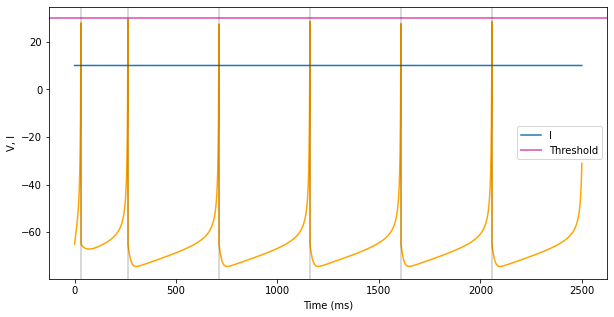

In [ ]:
# RS (regular spiking)
Izh_spiking_model(d=8)

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  0.2 
        c =  -55 
        d =  4 
        cInjection =  10 
        v0 =  -65 
        u0 =  -13.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


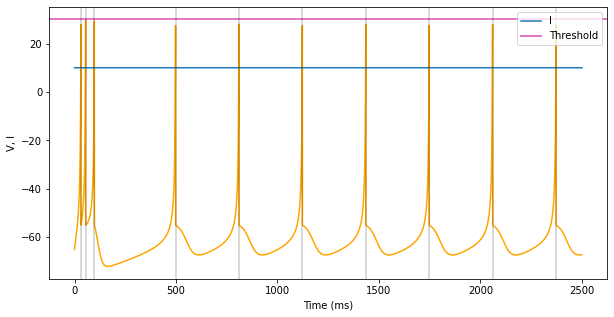

In [ ]:
# IB (intrinsically bursting)
Izh_spiking_model(c=-55, d=4)

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  0.2 
        c =  -50 
        d =  2 
        cInjection =  10 
        v0 =  -65 
        u0 =  -13.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


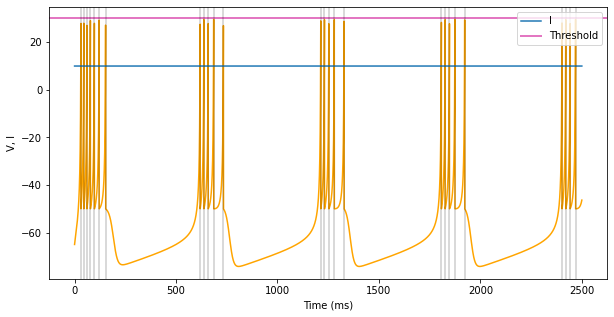

In [ ]:
# CH (chattering)
Izh_spiking_model(c = -50)

### Inhibitory cortical cell classes:

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.1 
        b =  0.2 
        c =  -65 
        d =  2 
        cInjection =  10 
        v0 =  -65 
        u0 =  -13.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


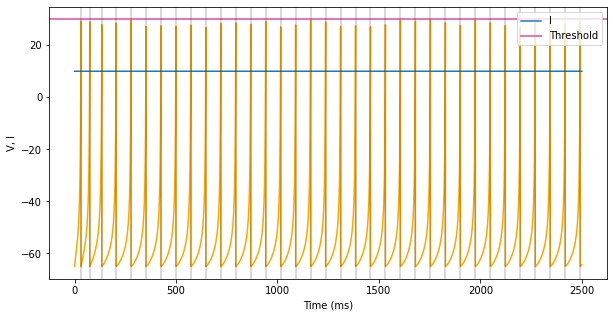

In [ ]:
# FS (fast spiking)
Izh_spiking_model(a=0.1)

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  0.25 
        c =  -65 
        d =  2 
        cInjection =  10 
        v0 =  -65 
        u0 =  -16.25 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


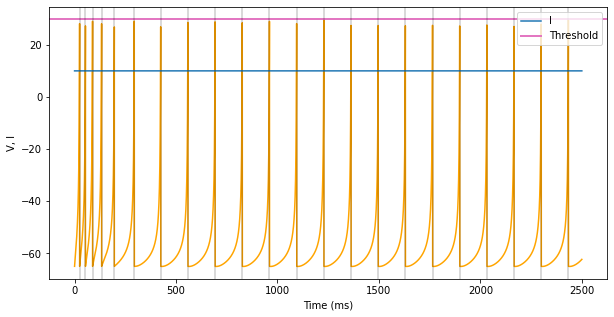

In [ ]:
# LTS (low-threshold spiking)
# Change b to 0.25
Izh_spiking_model(b=0.25)

### Thalamo-cortical neurons:

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  0.2 
        c =  -65 
        d =  2 
        cInjection =  5 
        v0 =  -63 
        u0 =  -12.600000000000001 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


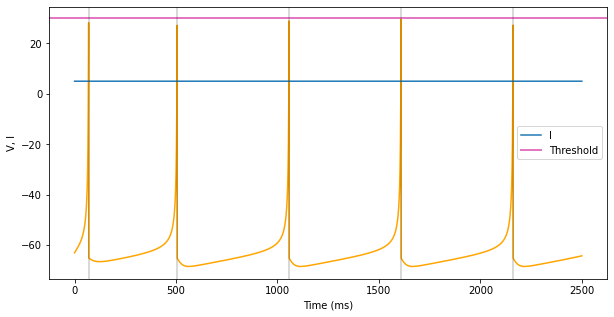

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  0.25 
        c =  -65 
        d =  0.05 
        cInjection =  -10*int(t<=300*ms) 
        v0 =  -90 
        u0 =  -22.5 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  750 
        injectionMode =  once


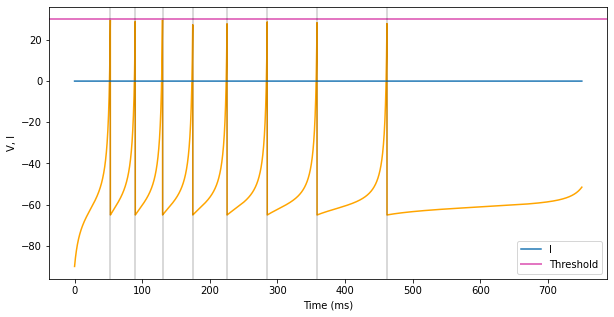

In [ ]:
# TC (thalamo-cortical)
# First
Izh_spiking_model(cInjection=5, v0=-63)
# Second
Izh_spiking_model(b = 0.25, d =0.05, cInjection="-10*int(t<=300*ms)", v0=-90, time = 750)

## Dynamics:

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.1 
        b =  0.26 
        c =  -65 
        d =  2 
        cInjection =  int(t>300*ms and t<320*ms)*10 
        v0 =  -65 
        u0 =  -16.900000000000002 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  600 
        injectionMode =  dinamic


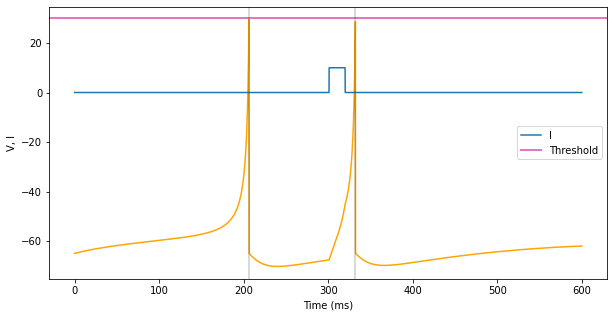

In [ ]:
# RZ (resonator)
Izh_spiking_model(a = 0.1,b = 0.26,
                  cInjection = "int(t>300*ms and t<320*ms)*10", 
                  time = 600, injectionMode= "dinamic")

## Neuro-Computational Features:

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  0.2 
        c =  -65 
        d =  6 
        cInjection =  10 
        v0 =  -65 
        u0 =  -13.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


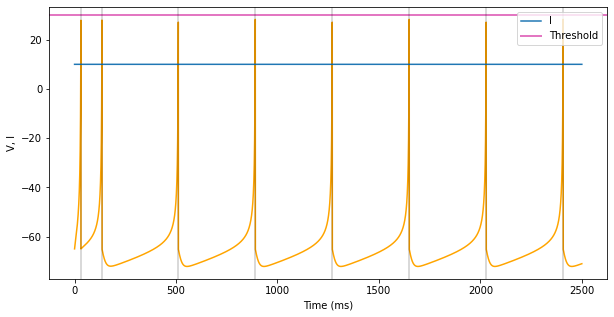

In [ ]:
# Paper 4
# (A) Tonic Spiking
Izh_spiking_model(a=0.02, b=0.20, c=-65, d=6, cInjection= 10 )

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  0.25 
        c =  -65 
        d =  6 
        cInjection =  1 
        v0 =  -65 
        u0 =  -16.25 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


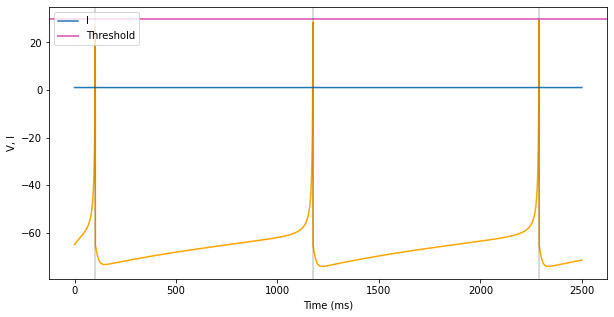

In [ ]:
# (B) Phasic Spiking
Izh_spiking_model(a=0.02, b=0.25, c=-65, d=6, cInjection= 1 )

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  0.2 
        c =  -50 
        d =  2 
        cInjection =  15 
        v0 =  -65 
        u0 =  -13.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


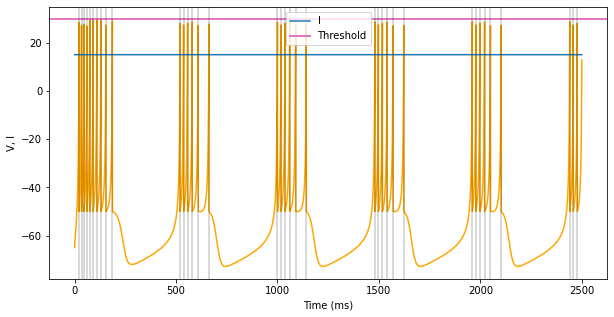

In [ ]:
# (C) Tonic Bursting
Izh_spiking_model(a=0.02, b=0.20, c=-50, d=2, cInjection= 15 )

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  0.25 
        c =  -55 
        d =  0.05 
        cInjection =  0.6 
        v0 =  -65 
        u0 =  -16.25 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


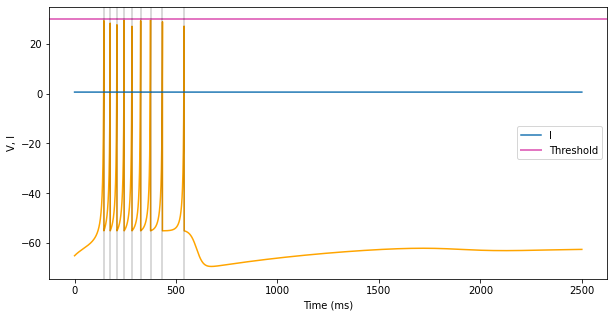

In [ ]:
# (D) Phasic Bursting
Izh_spiking_model(a=0.02, b=0.25, c=-55, d=0.05, cInjection= 0.6 )

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  0.2 
        c =  -55 
        d =  4 
        cInjection =  10 
        v0 =  -65 
        u0 =  -13.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


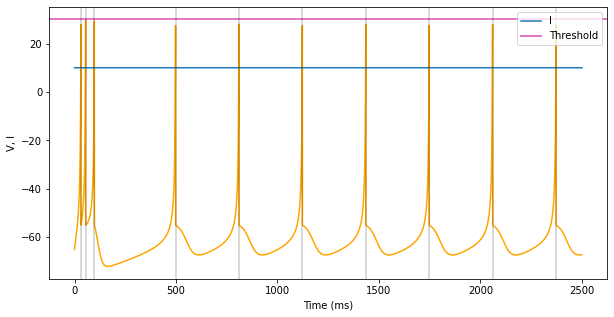

In [ ]:
# (E) Mixed Mode
Izh_spiking_model(a=0.02, b=0.20, c=-55, d=4, cInjection= 10 )

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.01 
        b =  0.2 
        c =  -65 
        d =  8 
        cInjection =  30 
        v0 =  -65 
        u0 =  -13.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


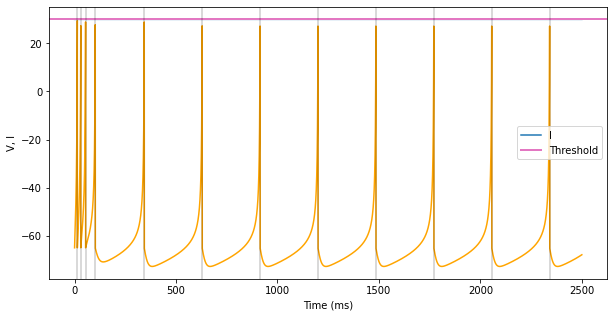

In [ ]:
# (F) Spike Frequency Adaptation
Izh_spiking_model(a=0.01, b=0.20, c=-65, d=8, cInjection= 30 )

WARNING    /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
 [py.warnings]


The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  -0.1 
        c =  -55 
        d =  6 
        cInjection =  0.075*(t/ms-30)*int(t>30*ms) 
        v0 =  -60 
        u0 =  6.0 
        k1 =  0.04 
        k2 =  4.1 
        k3 =  108.0 
        tau =  5 
        Time =  500 
        injectionMode =  dinamic


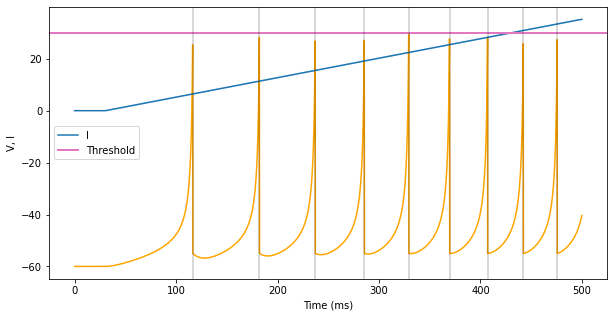

In [ ]:
# (G) Class 1 Excitable
Izh_spiking_model(a=0.02, b=-0.1, c=-55, d=6, 
                  cInjection = "0.075*(t/ms-30)*int(t>30*ms)", v0 = -60, tau = 5, time = 500, 
                  diferential_constants=np.array([0.04, 4.1, 108]), injectionMode="dinamic")


The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.2 
        b =  0.26 
        c =  -65 
        d =  0 
        cInjection =  (-0.5+(0.015*(t/ms-30))*int(t>30*ms))+(-0.5*int(t<=30*ms)) 
        v0 =  -64 
        u0 =  -16.64 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  5 
        Time =  700 
        injectionMode =  dinamic


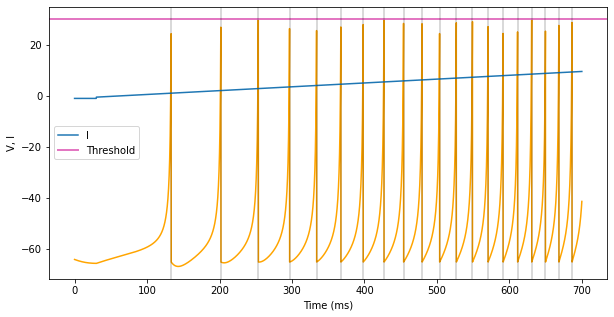

In [ ]:
# (H) Class 2 Excitable
Izh_spiking_model(a=0.2, b=0.26, c=-65, d=0, 
                  cInjection = "(-0.5+(0.015*(t/ms-30))*int(t>30*ms))+(-0.5*int(t<=30*ms))", 
                  v0 = -64, tau=5, time = 700, injectionMode="dinamic")


The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  0.2 
        c =  -65 
        d =  6 
        cInjection =  7.04*int(t>70*ms and t < 80*ms) 
        v0 =  -70 
        u0 =  -14.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  3.2 
        Time =  300 
        injectionMode =  dinamic


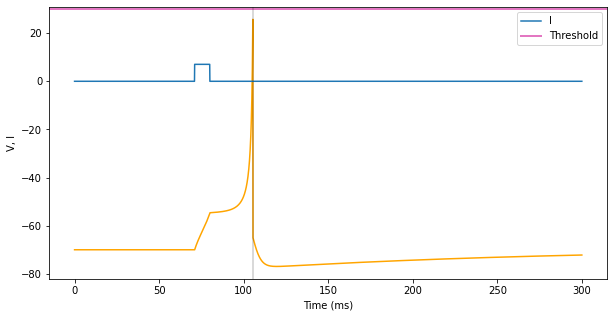

In [ ]:
# (I) Spike Latency
Izh_spiking_model(d=6, 
                  cInjection = "7.04*int(t>70*ms and t < 80*ms)", 
                  v0 = -70, tau=3.2, time = 300, injectionMode="dinamic")

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.05 
        b =  0.26 
        c =  -60 
        d =  0 
        cInjection =  0 
        v0 =  -65 
        u0 =  -16.900000000000002 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  2500 
        injectionMode =  once


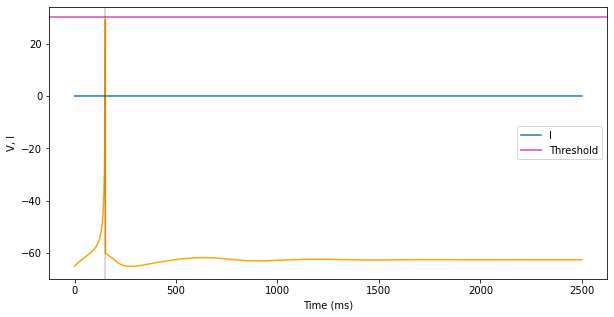

In [ ]:
# (J) Subthreshold Oscillations
Izh_spiking_model(a=0.05, b=0.26, c=-60, d=0, cInjection= 0 )

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.1 
        b =  0.26 
        c =  -60 
        d =  -1 
        cInjection =  int((t>70*ms and t<78*ms) or (t>110*ms and t<118*ms) or (t>530*ms and t<538*ms) or (t>640*ms and t<658*ms))*0.65 
        v0 =  -62 
        u0 =  -16.12 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  4 
        Time =  1000 
        injectionMode =  dinamic


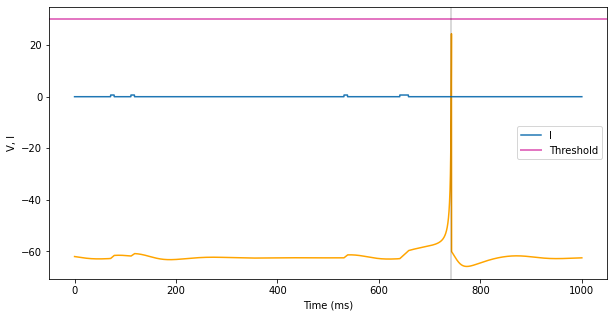

In [ ]:
# (K) Resonator
# We need to create the "4" steps seen on the figure
Izh_spiking_model(a=0.1, b=0.26, c=-60, d=-1, tau = 4,
                  cInjection = "int((t>70*ms and t<78*ms) or (t>110*ms and t<118*ms) or (t>530*ms and t<538*ms) or (t>640*ms and t<658*ms))*0.65", 
                  v0 = -62, time = 1000, injectionMode="dinamic")

WARNING    /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
 [py.warnings]


The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  -0.1 
        c =  -55 
        d =  6 
        cInjection =  9*int((t>10*ms and t<18*ms) or (t>31*ms and t<41*ms) or (t>264*ms and t<270*ms) or (t>290*ms and t<294*ms)) 
        v0 =  -64 
        u0 =  6.4 
        k1 =  0.04 
        k2 =  4.1 
        k3 =  108.0 
        tau =  3 
        Time =  350 
        injectionMode =  dinamic


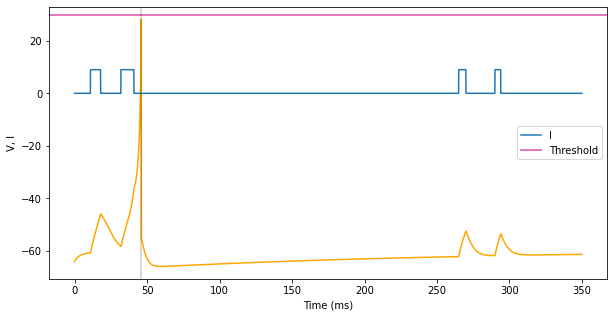

In [ ]:
# (L) Integrator
Izh_spiking_model(b=-0.1, c=-55, d=6, 
                  cInjection = "9*int((t>10*ms and t<18*ms) or (t>31*ms and t<41*ms) or (t>264*ms and t<270*ms) or (t>290*ms and t<294*ms))", 
                  v0 = -64, tau = 3, time = 350, diferential_constants=np.array([0.04, 4.1, 108]), injectionMode="dinamic")

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.03 
        b =  0.25 
        c =  -60 
        d =  4 
        cInjection =  -15*int(60*ms<t and t<120*ms) 
        v0 =  -64 
        u0 =  -16.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  5 
        Time =  700 
        injectionMode =  dinamic


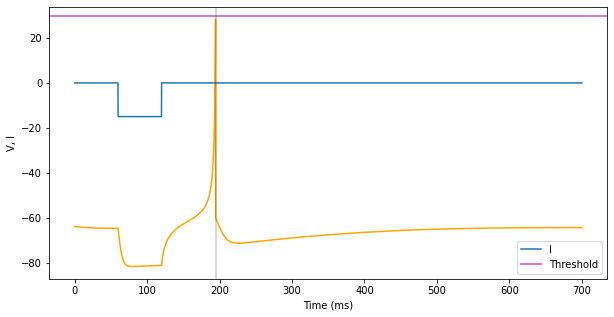

In [ ]:
# (M) Rebound Spike
Izh_spiking_model(a=0.03, b=0.25, c=-60, d=4, tau = 5,
                  cInjection = "-15*int(60*ms<t and t<120*ms)", 
                  v0 = -64, time = 700, injectionMode="dinamic")

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.03 
        b =  0.25 
        c =  -52 
        d =  0 
        cInjection =  -15*int(70*ms<t and t<120*ms) 
        v0 =  -64 
        u0 =  -16.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  5 
        Time =  700 
        injectionMode =  dinamic


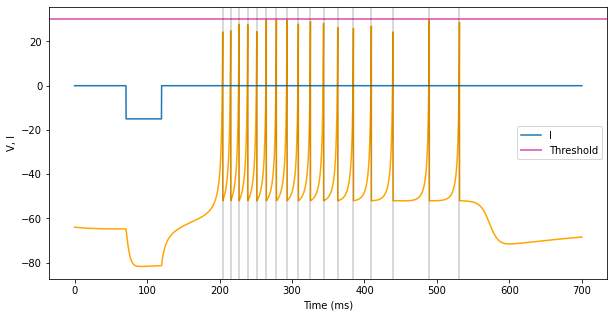

In [ ]:
# (N) Rebound Burst
Izh_spiking_model(a=0.03, b=0.25, c=-52, d=0, tau = 5,
                  cInjection = "-15*int(70*ms<t and t<120*ms)", 
                  v0 = -64, time = 700, injectionMode="dinamic")

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.03 
        b =  0.25 
        c =  -60 
        d =  4 
        cInjection =  (1.5*int((10*ms<t and t<20*ms) or (150*ms <t and t<175*ms))) + -6*int(120*ms<t and t<140*ms) 
        v0 =  -64 
        u0 =  -16.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  5 
        Time =  300 
        injectionMode =  dinamic


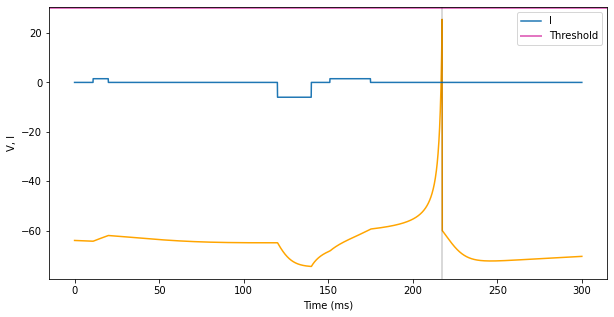

In [ ]:
# (O) Threshold variability
Izh_spiking_model(a=0.03, b=0.25, c=-60, d=4, tau = 5,
                  cInjection = "(1.5*int((10*ms<t and t<20*ms) or (150*ms <t and t<175*ms))) + -6*int(120*ms<t and t<140*ms)", 
                  v0 = -64, time = 300, injectionMode="dinamic")

The chosen parameters are: 
        Number of Neurons =  1 
        a =  1 
        b =  1.5 
        c =  -60 
        d =  0 
        cInjection =  -65 
        v0 =  -65 
        u0 =  -97.5 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  300 
        injectionMode =  once


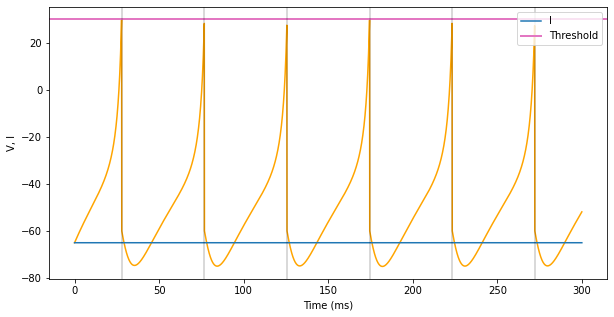

In [ ]:
# (P) Bistability
Izh_spiking_model(a=1, b=1.5, c=-60, d=0, cInjection= -65, tau = 10, time = 300)

The chosen parameters are: 
        Number of Neurons =  1 
        a =  1 
        b =  0.2 
        c =  -60 
        d =  -20 
        cInjection =  int(t>16*ms and t<30*ms)*20 
        v0 =  -70 
        u0 =  -14.0 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  10 
        Time =  175 
        injectionMode =  dinamic


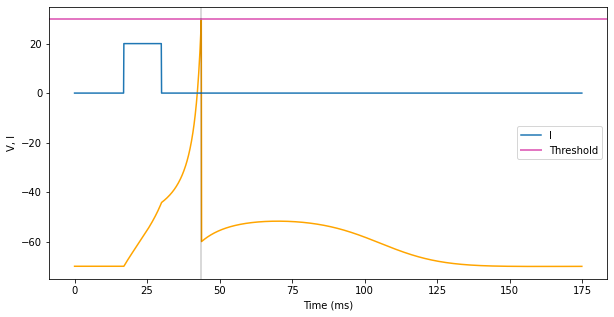

In [ ]:
# (Q) Depolarizing After-Potential
Izh_spiking_model(a=1, b=0.2, c=-60, d=-20, tau = 10,
                  cInjection = "int(t>16*ms and t<30*ms)*20", 
                  v0 = -70, time = 175, injectionMode="dinamic")

The chosen parameters are: 
        Number of Neurons =  1 
        a =  0.02 
        b =  1 
        c =  -55 
        d =  4 
        cInjection =  ((t/ms)/25)*int(t<190*ms)+((t/ms-300)/12.5*4)*int(t>=300*ms and t<312.5*ms) 
        v0 =  -70 
        u0 =  -16 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  50 
        Time =  1000 
        injectionMode =  dinamic


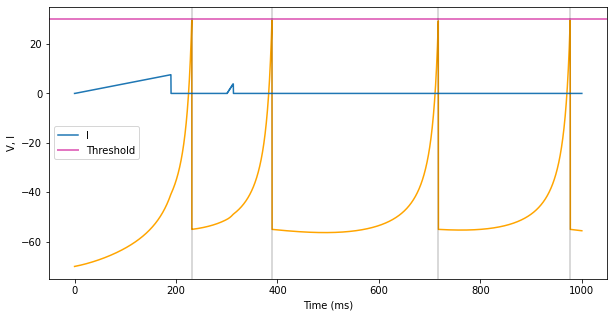

In [ ]:
# (R) Accomodation
# Our model cannot get a perfect recreation of the pattern
Izh_spiking_model(b=1, c=-55, d=4, tau = 50,
                  cInjection = "((t/ms)/25)*int(t<190*ms)+((t/ms-300)/12.5*4)*int(t>=300*ms and t<312.5*ms)",
                  u0= -16, v0 = -70, time = 1000,
                  injectionMode="dinamic")

The chosen parameters are: 
        Number of Neurons =  1 
        a =  -0.02 
        b =  -1 
        c =  -60 
        d =  8 
        cInjection =  75 
        v0 =  -65 
        u0 =  65 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  5 
        Time =  800 
        injectionMode =  once


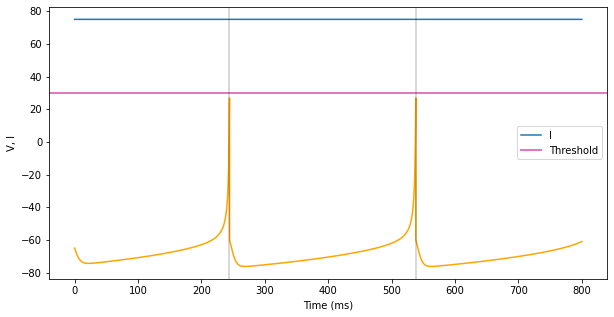

In [ ]:
# (S) Inhibition Induced Spiking
Izh_spiking_model(a=-0.02, b=-1, c=-60, d=8, v0=-65, tau=5, cInjection= 75, time = 800 )

The chosen parameters are: 
        Number of Neurons =  1 
        a =  -0.026 
        b =  -1 
        c =  -45 
        d =  0 
        cInjection =  75 
        v0 =  -65 
        u0 =  65 
        k1 =  0.04 
        k2 =  5 
        k3 =  140 
        tau =  5 
        Time =  1000 
        injectionMode =  once


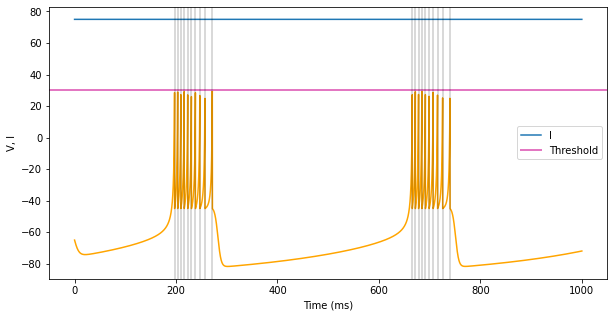

In [ ]:
# (T) Inhibition Induced Bursting
Izh_spiking_model(a=-0.026, b=-1, c=-45, d=0, v0=-65, tau=5, cInjection= 75, time = 1000 )

# References:



All the origianl figures for the different results presented here can be found here:



*   [Type and Dinamics.](https://www.izhikevich.org/publications/spikes.pdf)
*   [Neuro-Conputational Features.](https://www.izhikevich.org/publications/whichmod.pdf)

